In [242]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [226]:
#importing raw data for housing prices
raw_data= pd.read_csv('C:\data\hw.csv', low_memory=False)
#importing raw data for yearly unemployment rate
raw_unemp_data= pd.read_csv(r'C:\data\unemployment_rate.csv')
#importing raw data for yearly gdp
raw_gdp_data= pd.read_csv(r'C:\data\HK GDP.csv')

Cleaning the housing data below

In [262]:
#removing all the unwanted columns
data = raw_data[['catname', 'catfathername', 'price_value', 'act_area', 'arearaw', 'sq_price_value', 'sq_actprice_value', 
                  'date_dm','date_y']]
#renaming the columns 
data = data.rename(columns={'catname': 'Estate', 'catfathername': 'District', 'price_value': 'Total price', 
                              'act_area': 'SFA', 'arearaw': 'GFA', 'sq_price_value': 'Average unit price(GFA)', 
                              'sq_actprice_value': 'Average unit price(SFA)', 'date_dm': 'Transaction Date', 
                              'date_y': 'Year',})

#modifying the values to remove the unit
data['SFA'] = data['SFA'].str.extract('(\d+)').astype(float)

#standardizing the data format
data['GFA'] = pd.to_numeric(data['GFA'], errors='coerce')

#converting the datatype to datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], format= '%d/%m', errors= 'coerce')
data['Year'] = pd.to_datetime(data['Year'], format='%Y', errors= 'coerce')

#creating a new column with the full date
data['Full Transaction Date'] = pd.to_datetime(data['Year'].dt.strftime('%Y') + 
                                            data['Transaction Date'].dt.strftime('-%m-%d'))
#removing the component columns 
data = data.drop(['Transaction Date', 'Year'], axis=1)
data

,Estate,District,Total price,SFA,GFA,Average unit price(GFA),Average unit price(SFA),Full Transaction Date
0,Bel Air Heights,Diamond Hill,10000000,657.0,826.0,12106.54,15220.70,2020-11-27
1,Fa Yuen Plaza,Mong Kok,4280000,214.0,347.0,12334.29,20000.00,2020-11-27
2,Caldecott Hill,Yau Yat Tsuen,11000000,991.0,1282.0,8580.34,11099.90,2020-11-27
3,Pang Ching Court,Wong Tai Sin,4900000,NaN,583.0,8404.80,0.00,2020-11-27
4,Metro Harbour View,Tai Kok Tsui,7150000,412.0,595.0,12016.81,17354.37,2020-11-27
...,...,...,...,...,...,...,...,...
79995,Amoy Gardens,Kowloon Bay,4350000,391.0,501.0,8682.63,11125.32,2014-10-27
79996,Marple Court,Kowloon Tong,7500000,678.0,850.0,8823.53,11061.95,2014-10-27
79997,Harbour Place,Hung Hom,6500000,481.0,630.0,10317.46,13513.51,2014-10-27
79998,Richland Gardens,Kowloon Bay,3790000,NaN,470.0,8063.83,0.00,2014-10-27


In [263]:
#handling na value 
#counting the number of missing values in each column
print(data.isna().sum())

Estate                         0
District                       0
Total price                    0
SFA                        41743
GFA                            4
Average unit price(GFA)        0
Average unit price(SFA)        0
Full Transaction Date         35
dtype: int64


In [264]:
#removing the rows with missing values for GFA and Transaction date 
data = data.dropna(subset=['GFA', 'Full Transaction Date'])

#checking if any column has 0 value
print((data == 0).sum())

Estate                         0
District                       0
Total price                    0
SFA                            0
GFA                        30492
Average unit price(GFA)    30492
Average unit price(SFA)    41716
Full Transaction Date          0
dtype: int64


In [265]:
#removing rows with 0 in GFA and Average unit price(GFA)
data = data.drop(data[data['GFA'] == 0].index)

#filling in the missing value for SFA
subset= data.dropna()
ratio= (subset['SFA']/subset['GFA']).mean()
data['SFA'] = data['SFA'].fillna(data['GFA']*ratio)
data['Average unit price(SFA)']= data['Total price']/data['SFA']

#checking to see if there is still any na or zero left 
print("Columns with missing values")
print(data.isna().sum())
print("Columns with zero values")
print((data == 0).sum())

Columns with missing values
Estate                     0
District                   0
Total price                0
SFA                        0
GFA                        0
Average unit price(GFA)    0
Average unit price(SFA)    0
Full Transaction Date      0
dtype: int64
Columns with zero values
Estate                     0
District                   0
Total price                0
SFA                        0
GFA                        0
Average unit price(GFA)    0
Average unit price(SFA)    0
Full Transaction Date      0
dtype: int64


Merging the housing data with the unemployment data

In [266]:
#cleaning the unemployment data
#removing the unwanted rows and columns 
unemp_data= raw_unemp_data.loc[:6,['Year', 'Unemployment Rate']]
#changing the data format
unemp_data['Year'] = pd.to_datetime(unemp_data['Year'], format='%Y')
unemp_data

,Year,Unemployment Rate
0,2014-01-01,3.30
1,2015-01-01,3.32
2,2016-01-01,3.39
3,2017-01-01,3.12
4,2018-01-01,2.81
5,2019-01-01,2.92
6,2020-01-01,5.81


In [267]:
#merging the two data sets 
#function to fill in unemployment rate
def unemp_rate(year): 
    return float(unemp_data[unemp_data["Year"].dt.year == year]["Unemployment Rate"].values)
#applying above function to create a new column with unemployment rate in housing data
data['Unemployment Rate'] = data['Full Transaction Date'].dt.year.apply(lambda x: unemp_rate(x))

In [268]:
data

,Estate,District,Total price,SFA,GFA,Average unit price(GFA),Average unit price(SFA),Full Transaction Date,Unemployment Rate
0,Bel Air Heights,Diamond Hill,10000000,657.000000,826.0,12106.54,15220.700152,2020-11-27,5.81
1,Fa Yuen Plaza,Mong Kok,4280000,214.000000,347.0,12334.29,20000.000000,2020-11-27,5.81
2,Caldecott Hill,Yau Yat Tsuen,11000000,991.000000,1282.0,8580.34,11099.899092,2020-11-27,5.81
3,Pang Ching Court,Wong Tai Sin,4900000,447.161956,583.0,8404.80,10957.998407,2020-11-27,5.81
4,Metro Harbour View,Tai Kok Tsui,7150000,412.000000,595.0,12016.81,17354.368932,2020-11-27,5.81
...,...,...,...,...,...,...,...,...,...
79995,Amoy Gardens,Kowloon Bay,4350000,391.000000,501.0,8682.63,11125.319693,2014-10-27,3.30
79996,Marple Court,Kowloon Tong,7500000,678.000000,850.0,8823.53,11061.946903,2014-10-27,3.30
79997,Harbour Place,Hung Hom,6500000,481.000000,630.0,10317.46,13513.513514,2014-10-27,3.30
79998,Richland Gardens,Kowloon Bay,3790000,360.490771,470.0,8063.83,10513.445306,2014-10-27,3.30


Creating aggregated dataframe with monthly average unit price per district 

In [269]:
#creating a subset with only the required columns 
dis_data= data.loc[:,['District', 'Average unit price(GFA)', 'Average unit price(SFA)']]
#changing the datatype to year month
dis_data.loc[:, 'Year Month'] = data.loc[:,'Full Transaction Date'].dt.strftime('%Y-%m')
#grouping the data according to district and year month for average unit price (GFA)
dis_GFA= dis_data.groupby(['District', 'Year Month'])["Average unit price(GFA)"].mean()
#grouping the data according to district and year month for average unit price (SFA)
dis_SFA= dis_data.groupby(['District', 'Year Month'])["Average unit price(SFA)"].mean()
#changing it into dataframe with proper column names 
dis_GFA= dis_GFA.reset_index(name='Average unit price(GFA)').set_index("District")
dis_SFA= dis_SFA.reset_index(name='Average unit price(SFA)').set_index("District")

In [270]:
dis_GFA

,Year Month,Average unit price(GFA)
District,,
Cheung Sha Wan,2014-10,7786.005714
Cheung Sha Wan,2014-11,8533.943333
Cheung Sha Wan,2014-12,8137.849268
Cheung Sha Wan,2015-01,8000.584483
Cheung Sha Wan,2015-02,8208.579783
...,...,...
Yau Yat Tsuen,2020-07,16228.127778
Yau Yat Tsuen,2020-08,16455.528571
Yau Yat Tsuen,2020-09,15084.295000


In [271]:
dis_SFA

,Year Month,Average unit price(SFA)
District,,
Cheung Sha Wan,2014-10,10193.534616
Cheung Sha Wan,2014-11,11285.113743
Cheung Sha Wan,2014-12,10741.346355
Cheung Sha Wan,2015-01,10480.222194
Cheung Sha Wan,2015-02,10655.016561
...,...,...
Yau Yat Tsuen,2020-07,20527.827816
Yau Yat Tsuen,2020-08,20609.655418
Yau Yat Tsuen,2020-09,17737.412982


Creating aggregated dataframe with monthly average unit price per estate

In [177]:
#creating a subset with the required columns 
est_data= data.loc[:,['Estate', 'Average unit price(GFA)', 'Average unit price(SFA)']]
#changing the data type to year month
est_data.loc[:, 'Year Month'] = data.loc[:,'Full Transaction Date'].dt.strftime('%Y-%m')
#grouping the data according to estate and year month for average unit price (GFA)
est_GFA= est_data.groupby(['Estate', 'Year Month'])["Average unit price(GFA)"].mean()
#grouping the data according to estate and year month for average unit price (SFA)
est_SFA= est_data.groupby(['Estate', 'Year Month'])["Average unit price(SFA)"].mean()
#changing it into dataframe with proper column names 
est_GFA= est_GFA.reset_index(name='Average unit price(GFA)').set_index("Estate")
est_SFA= est_SFA.reset_index(name='Average unit price(SFA)').set_index("Estate")

In [272]:
est_GFA

,Year Month,Average unit price(GFA)
Estate,,
1 Lion Rock Rd,2016-02,6843.830000
1 Lion Rock Rd,2016-10,11348.310000
1 Lion Rock Rd,2017-09,12051.840000
1 Lion Rock Rd,2019-08,13820.220000
1 Lion Rock Rd,2020-02,15011.240000
...,...,...
i-home,2020-06,12037.453333
i-home,2020-08,12008.065000
i-home,2020-09,12396.250000


In [273]:
est_SFA

,Year Month,Average unit price(SFA)
Estate,,
1 Lion Rock Rd,2016-02,8922.839614
1 Lion Rock Rd,2016-10,14795.684939
1 Lion Rock Rd,2017-09,15712.920587
1 Lion Rock Rd,2019-08,18018.507401
1 Lion Rock Rd,2020-02,19571.321860
...,...,...
i-home,2020-06,16042.303872
i-home,2020-08,15986.024537
i-home,2020-09,16830.348940


Data visualization

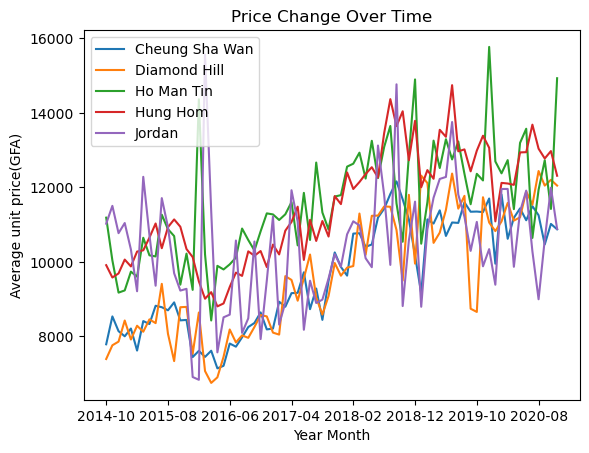

In [280]:
#visualizing the price changes for 5 districts together 
#selecting 5 districts from the dataset 
vis_trial = dis_GFA.loc[dis_GFA.index.unique()[:5]].reset_index()
#here GFA is used as it did not have many missing data, hence making it more reliable 
#pivoting the data to make it appropriate for visualization
vis_trial1 = vis_trial.pivot(index='Year Month', columns='District', values='Average unit price(GFA)')
vis_trial1.plot(kind='line')
plt.xlabel('Year Month')
plt.ylabel('Average unit price(GFA)')
plt.title('Price Change Over Time')
plt.legend()
plt.show()

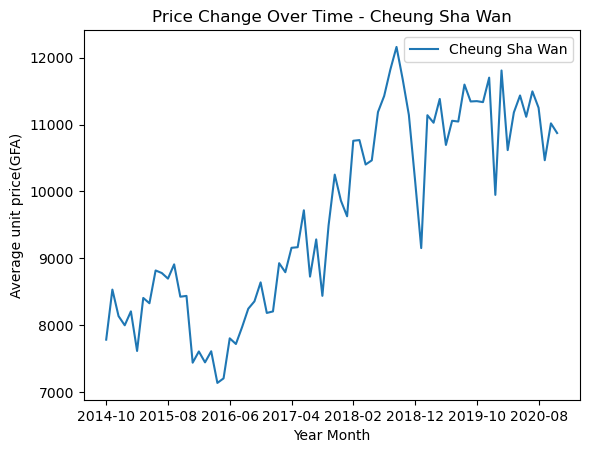

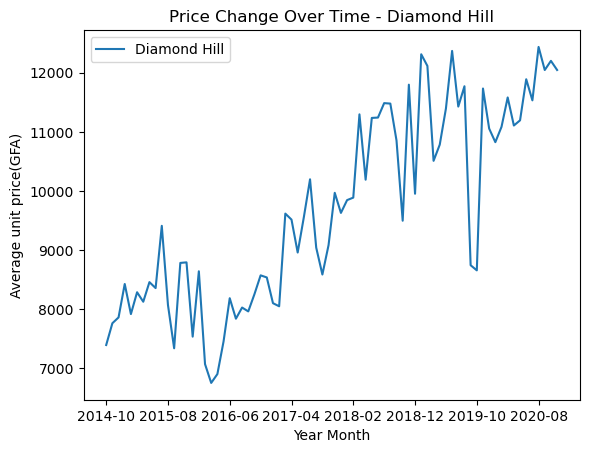

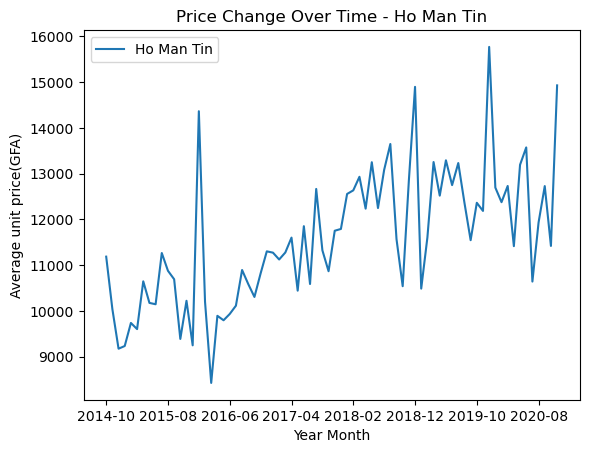

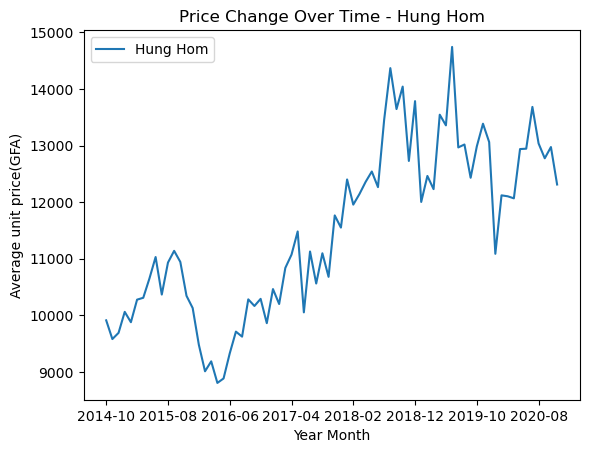

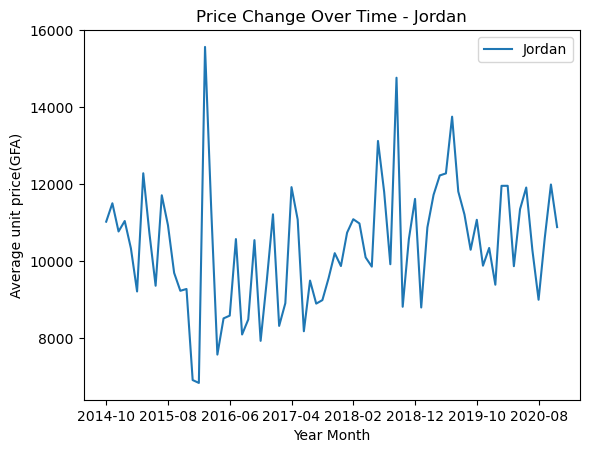

In [281]:
#creating a plot for each district seperately 
#getting all the district values 
districts = vis_trial['District'].unique()

for district in districts:
    district_df = vis_trial[vis_trial['District'] == district]
    district_df.plot(x='Year Month', y='Average unit price(GFA)', kind='line', label=district)
    plt.xlabel('Year Month')
    plt.ylabel('Average unit price(GFA)')
    plt.title(f'Price Change Over Time - {district}')
    plt.legend()
    plt.show()

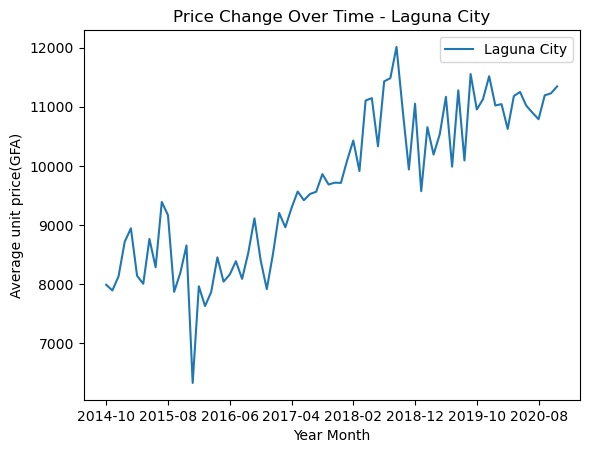

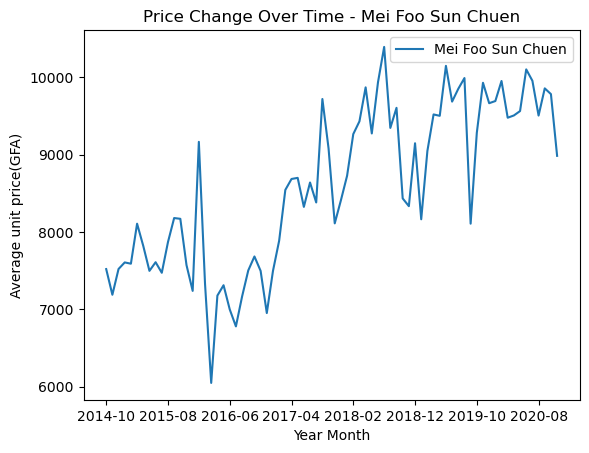

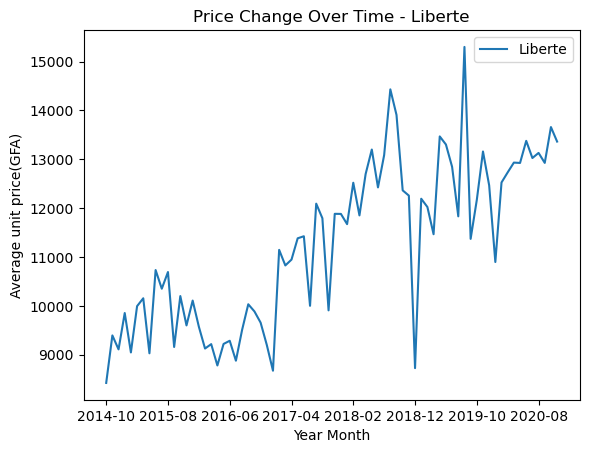

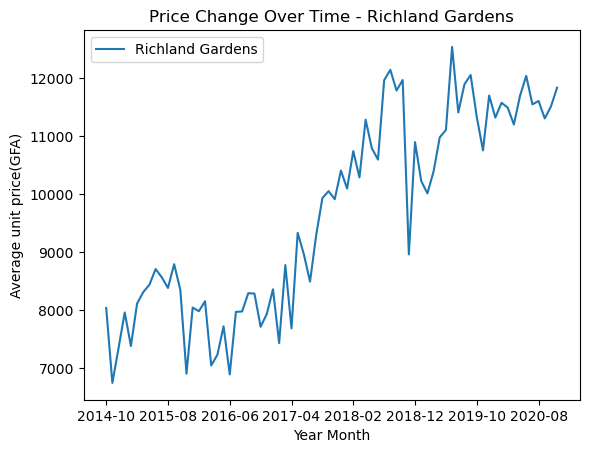

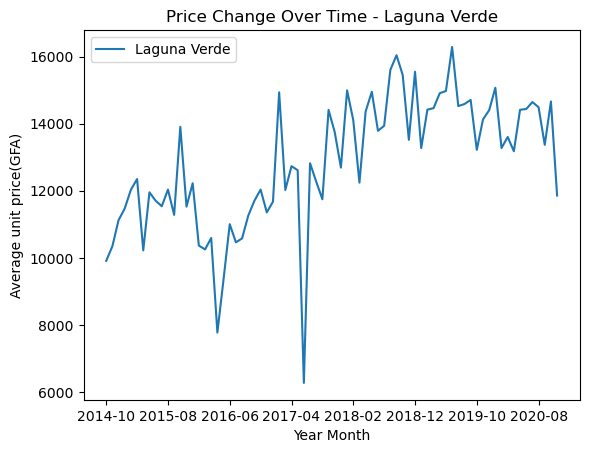

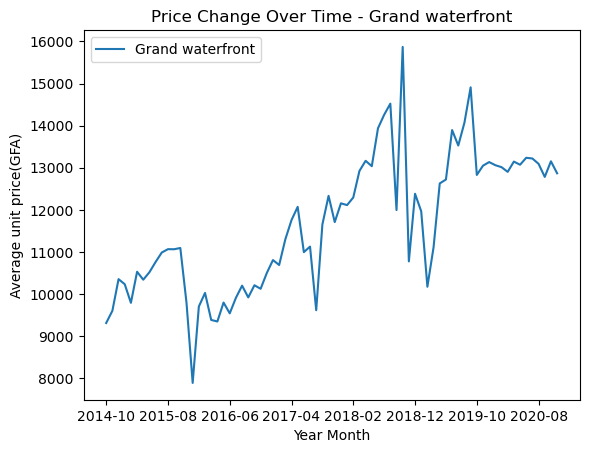

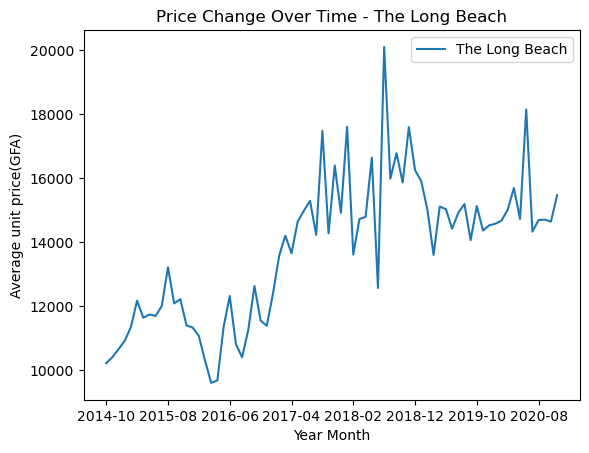

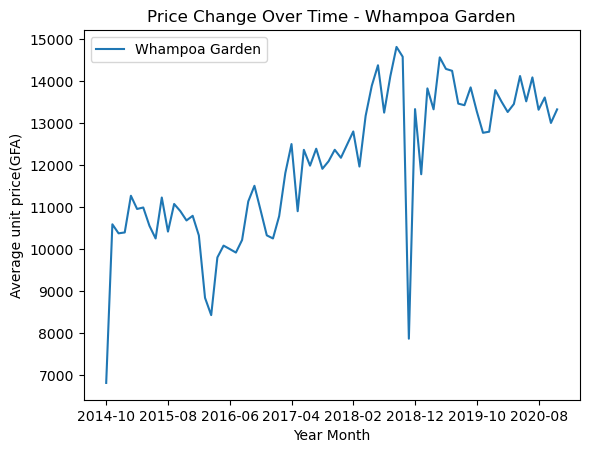

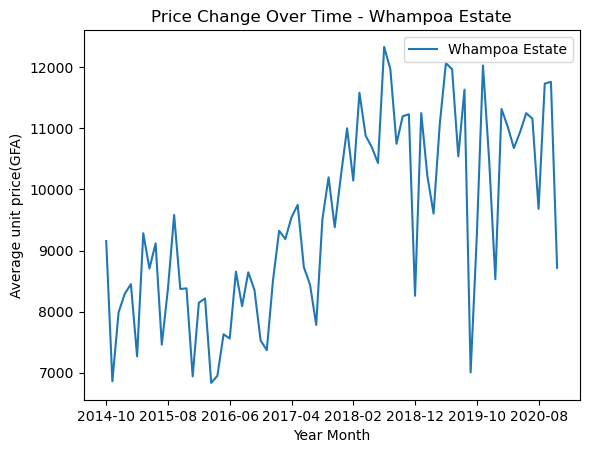

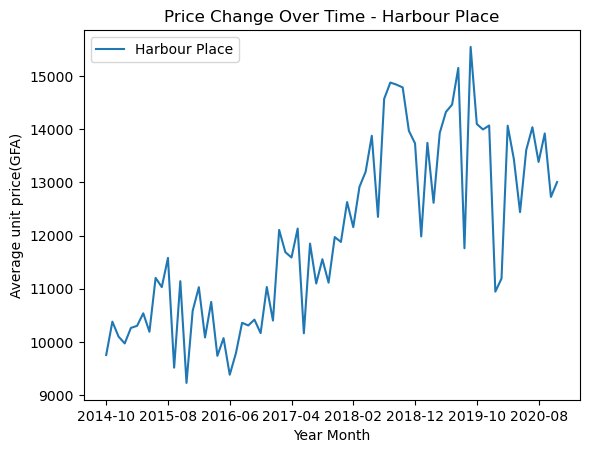

In [284]:
#choose 10 estates with the most number of data 
req_estates= est_GFA.index.value_counts().nlargest(10).index
#creating a new dataframe with the selected 10 estates 
req_est_data= est_GFA[est_GFA.index.isin(req_estates)].reset_index()

# Plot each estate separately
for estate in req_estates:
    estate_df = req_est_data[req_est_data['Estate'] == estate]
    estate_df.plot(x='Year Month', y='Average unit price(GFA)', kind='line', label=estate)
    plt.xlabel('Year Month')
    plt.ylabel('Average unit price(GFA)')
    plt.title(f'Price Change Over Time - {estate}')
    plt.legend()
    plt.show()

Data analysis- finding the relation with unemployment data

In [285]:
#finding the correlation of average price with unemployment rate 
#grouping the data to have the average price for different years 
yearly_price = data.groupby(data['Full Transaction Date'].dt.year)['Average unit price(GFA)'].mean()
#here GFA is used as it did not have many missing values 

#creating a dataframe with more appropriate column names 
yearly_price = yearly_price.reset_index(name="Average unit price(GFA)")
yearly_price = yearly_price.rename(columns={yearly_price.columns[0]: "Year"})

#creating a column with the unemployment rate 
yearly_price['Unemployment Rate'] = yearly_price['Year'].apply(lambda x: unemp_rate(x))
#finding the correlation coefficient of average unit price and unemployment rate 
unemp_correlation = yearly_price['Average unit price(GFA)'].corr(yearly_price['Unemployment Rate'])
print('Correlation is between Average unit price (GFA) and unemployment is {}'.format(unemp_correlation))

Correlation is between Average unit price (GFA) and unemployment is 0.25437280738174883


A weak correlation is observed between average unit price and unemployment rate 

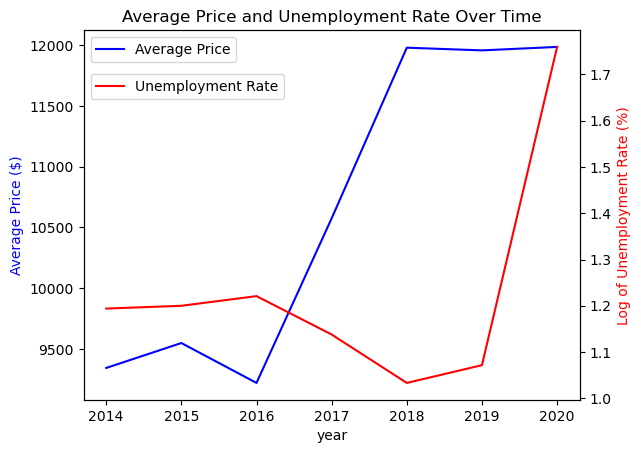

In [286]:
#plotting the relation between average price and unemployment rate 

# Create the figure and axis objects
fig, ax1 = plt.subplots()

# Plot the average price on the left Y-axis
ax1.plot(yearly_price['Year'], yearly_price['Average unit price(GFA)'], 'b-')
ax1.set_xlabel('year')
ax1.set_ylabel('Average Price ($)', color='b')

# Create a second Y-axis object
ax2 = ax1.twinx()
# Plot the unemployment rate on the right Y-axis
ax2.plot(yearly_price['Year'], np.log(yearly_price['Unemployment Rate']), 'r-')
ax2.set_ylabel('Log of Unemployment Rate (%)', color='r')
#log is used to amplify the changes in unemployment 

# Set the title and legend
plt.title('Average Price and Unemployment Rate Over Time')
ax1.legend(['Average Price'], loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(['Unemployment Rate'], loc='upper left', bbox_to_anchor=(0, 0.9))

# Show the plot
plt.show()

Housing prices increased significantly from 2016 to 2018. 
Even from the graph, there seems to be no relation with housing prices and unemployment. 

Data analysis- finding the relation with gdp data

In [287]:
#cleaning the gdp data
gdp_data= raw_gdp_data.loc[:,['Year', 'GDP']]
gdp_data['Year'] = pd.to_datetime(gdp_data['Year'], format='%Y')
gdp_data

,Year,GDP
0,2014-01-01,2.914600e+11
1,2015-01-01,3.093860e+11
2,2016-01-01,3.208600e+11
3,2017-01-01,3.412730e+11
4,2018-01-01,3.617310e+11
5,2019-01-01,3.630750e+11
6,2020-01-01,3.449430e+11


In [288]:
# merging gdp data with the yearly prices data
def gdp(year): 
    return float(gdp_data[gdp_data["Year"].dt.year == year]["GDP"].values)
yearly_price['GDP'] = yearly_price['Year'].apply(lambda x: gdp(x))
yearly_price

,Year,Average unit price(GFA),Unemployment Rate,GDP
0,2014,9343.829741,3.30,2.914600e+11
1,2015,9548.987256,3.32,3.093860e+11
2,2016,9220.649232,3.39,3.208600e+11
3,2017,10575.288873,3.12,3.412730e+11
4,2018,11979.759548,2.81,3.617310e+11
5,2019,11957.647605,2.92,3.630750e+11
6,2020,11986.097827,5.81,3.449430e+11


In [289]:
#finding the correlation coefficient of average unit price and gdp
gdp_correlation = yearly_price['Average unit price(GFA)'].corr(yearly_price['GDP'])
print('Correlation is between Average unit price (GFA) and GDP is {}'.format(gdp_correlation))

Correlation is between Average unit price (GFA) and GDP is 0.9007112284423482


Strong correlation between average housing prices and GDP

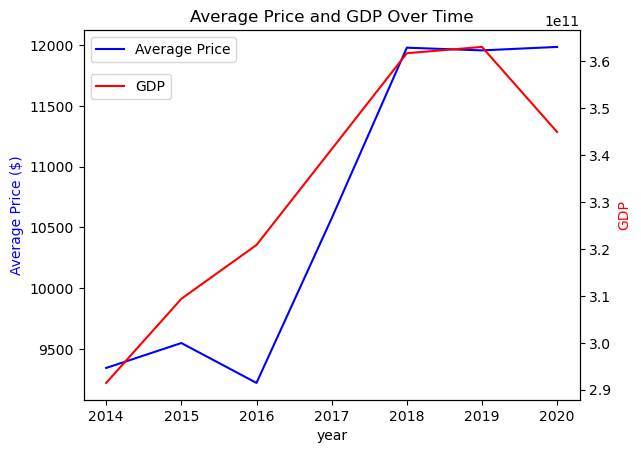

In [290]:
#plotting the relation between average price and gdp

# Create the figure and axis objects
fig, ax1 = plt.subplots()

# Plot the average price on the left Y-axis
ax1.plot(yearly_price['Year'], yearly_price['Average unit price(GFA)'], 'b-')
ax1.set_xlabel('year')
ax1.set_ylabel('Average Price ($)', color='b')

# Create a second Y-axis object
ax2 = ax1.twinx()
# Plot the GDP on the right Y-axis
ax2.plot(yearly_price['Year'], yearly_price['GDP'], 'r-')
ax2.set_ylabel('GDP', color='r')

# Set the title and legend
plt.title('Average Price and GDP Over Time')
ax1.legend(['Average Price'], loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(['GDP'], loc='upper left', bbox_to_anchor=(0, 0.9))

# Show the plot
plt.show()

From the graph, we can see that housing prices and GDP have similar trends
In Hong Kong, the supply of housing is almost fixed 
Increase in GDP indicates people having higher income, making them more willing to spend on housing, driving housing prices up 